# Proyecto - *Data Product Architecture* (Primavera 2021)
## *Chicago Food Inspections*
## Maestría en Ciencia de Datos, ITAM
### M. Sc. Liliana Millán Núñez
### *Checkpoint* 4: *Feature Engineering*
#### Equipo 5
---

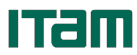

In [1]:
from IPython.display import Image
Image("itam_logo.png")

---

Integrante | Alumno                         | Clave única
---------- | ------------------------------ | -----------
1          | Carlos Román López Sierra      | 197911
2          | José Luis Zárate Cortés        | 183347
3          | Octavio Fuentes Ortiz          | 150792
4          | Patricia Urriza Arellano       | 152026
5          | Uriel Abraham Rangel Díaz      | 193921

Jueves 8 de abril de 2021

---

**¿Qué pregunta analítica buscamos contestar con nuestro modelo?** 

Buscamos contestar si el establecimiento pasará o no pasará la inspección.

---

Los paquetes que utilizamos son:
- [***numpy***](https://numpy.org/)
- [***pandas***](https://pandas.pydata.org/)
- [***geopandas***](https://geopandas.org/)
- [***shapely***](https://pypi.org/project/Shapely/)
- [***datetime***](https://docs.python.org/3/library/datetime.html)
- [***csv***](https://docs.python.org/3/library/csv.html)
- [***plotly express***](https://pypi.org/project/plotly-express/)
- [***matplotlib***](https://matplotlib.org/)
- [***seaborn***](https://seaborn.pydata.org/)

---

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from shapely import wkt
from datetime import datetime
from datetime import timedelta
import csv
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure
from sodapy import Socrata
import seaborn as sns 
import random

from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
import time 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

import pickle

Cargamos los datos desde la Api de Socrata

In [3]:
client = Socrata("data.cityofchicago.org", None)
results = client.get("4ijn-s7e5", limit=400000)
df = pd.DataFrame.from_records(results)
col_names = df.columns.to_list()
col_name = []
for i in range(len(col_names)):
    col_name.append(col_names[i].replace(" ", "_").lower())
df.columns =col_name
# Eliminamos el '_' que aparece al final en la columna 'license_'
df.rename(columns={'license_':'license'}, inplace=True)

In [4]:
pickle.dump(df,open("ingesta.pkl","wb"))

In [3]:
df = pickle.load(open("ingesta.pkl","rb"))

---

## Valores faltantes

Revisamos los *missing values* de nuestra base de datos:

In [4]:
missings_prop = df.apply(lambda x: round(x.isnull().sum()/df.shape[0]*100, 2))
missings_numeric_df = pd.DataFrame({'Proporción de valores faltantes': missings_prop})
missings_numeric_df

,Proporción de valores faltantes
inspection_id,0.00
dba_name,0.00
aka_name,1.14
license,0.01
facility_type,2.25
risk,0.03
address,0.00
city,0.08
state,0.02
zip,0.02


- Observamos que en la variable ***violations*** tenemos  casi un 27% de registros faltantes. Esto hace sentido pues es un campo abierto donde se redacta la o las violaciones en las que incurrió el negocio, sin embargo, cuando aparece el campo como vacío, esto podría ser porque el negocio pasó la inspección y por ende no incurrió en violación alguna.

- También observamos que falta el mismo porcentaje tanto en ***location***, como en ***latitude*** y ***longitude***. Por lo tanto, consideramos que podremos descartar más adelante la variable *location*, pues contiene información repetida.

- El porcentaje de faltantes en ***license*** es muy bajo. Consideramos que podemos simplemente eliminar estos valores.

---

## *Feature Selection*

**¿Qué variables debemos eliminar porque no las podremos tener en el momento de la predicción?**

Las variables que decidimos quitar son las siguientes, pues no se tendrán para el modelo:

- ***inspection_id***

- ***dba_name***

- ***adress***

- ***city***

- ***state***

- ***location***

- ***latitude***

- ***longitude***

**¿Qué variables debemos conservar porque sí las podremos tener en el momento de la predicción?**

- ***aka_name***

- ***license***

- ***facility_type***

- ***risk***

- ***zip***

- ***inspection_date***

- ***inspection_type***

- ***results***

- ***violations***

Las variables con las que no trabajaremos aún no las quitamos, pues algunas nos servirán para imputar valores faltantes. Por ejemplo, cuando ***'aka_name'*** no contenga información, imputaremos con el valor proporcionado con ***'dba_name'***. También porque hay variables como ***'violations'*** que se convertirán en ***'violations_count'***. Todo esto lo iremos explicando más adelante en el ***Feature Transformation***.

---

## *Feature Transformation*

¿Qué variables debemos transformar para facilitar el trabajo del modelo de clasificación?

### Transformación de variables



#### Variables de texto

Creamos la variable ***'violations_count'***, que nos permite saber en cuántas violaciones incurrió el establecimiento durante la inspección:

In [5]:
df['violations']= df['violations'].astype('object')

In [6]:
df['violations_count'] = df.violations.str.count(r'\|')+1

In [7]:
df['violations_count'] = df.violations_count.fillna(0)

In [8]:
df.drop(['violations'],axis = 1, inplace = True)

#### Variables categóricas

In [9]:
df['dba_name']= df['dba_name'].astype('category')
df['aka_name']= df['aka_name'].astype('category')
df['facility_type']= df['facility_type'].astype('category')
df['risk']= df['risk'].astype('category')
df['address']= df['address'].astype('category')
df['city']= df['city'].astype('category')
df['state']= df['state'].astype('category')
df['inspection_type']= df['inspection_type'].astype('category')
df['results']= df['results'].astype('category')

En la variable ***results***, tenemos 7 tipos de resultados distintos:

- ***Business Not Located***
- ***No Entry***
- ***Not Ready***
- ***Out of Business***
- ***Fail***
- ***Pass***
- ***Pass w/ Conditions***

Creamos una variable llamada ***'label_results'***, donde la etiqueta 0 implica que la inspección no pasó, la etiqueta 1 implica que la inspección sí pasó y por último, la etiqueta 2 en otro caso:

In [10]:
df_np1 = df[df['results'] == 'Fail']
df_np1['label_results'] = 0

df_np2 = df[df['results'] == 'Pass']
df_np2['label_results'] = 1

df_np3 = df[df['results'] == 'Pass w/ Conditions']
df_np3['label_results'] = 1

df_np4 = df[df['results'] == 'Business Not Located']
df_np4['label_results'] = 2

df_np5 = df[df['results'] == 'No Entry']
df_np5['label_results'] = 2

df_np6 = df[df['results'] == 'Not Ready']
df_np6['label_results'] = 2

df_np7 = df[df['results'] == 'Out of Business']
df_np7['label_results'] = 2

df = df_np1.append(df_np2).append(df_np3).append(df_np4).append(df_np5).append(df_np6).append(df_np7)

Quitamos la variable ***'results'***:

In [11]:
df.drop(['results'], axis = 1, inplace = True)

En nuestro ***GEDA*** observamos que los resultados que agrupamos con la etiqueta 2, juntos apenas representan poco más del 10% del total de las inspecciones. Aunado a esto, ya que no son resultados que impliquen directamente que el establecimiento no pasó o sí pasó la(s) inspección(es), los quitamos.

In [12]:
df.drop(df.loc[df['label_results'] == 2].index, inplace=True)

En la variable ***risk***, tenemos 5 tipos de resultados distintos:

- ***risk 1 (high)***
- ***risk 2 (medium)***
- ***risk 3 (low)***
- ***all***
- ***NaN***

Creamos una variable llamada ***'label_risk'***, donde la etiqueta 3 implica que el riesgo es ***risk 1 (high)***, la etiqueta 2 implica que el riesgo es ***risk 2 (medium)***, la etiqueta 1 implica que el riesgo es ***risk 3 (low)*** y la etiqueta 0 implica que el riesgo es ***all*** o ***valores nulos***:

In [13]:
df['risk'] = df['risk'].replace(["Risk 1 (High)"],3)

In [14]:
df['risk'] = df['risk'].replace(["Risk 2 (Medium)"],2)

In [15]:
df['risk'] = df['risk'].replace(["Risk 3 (Low)"],1)

In [16]:
df['risk'] = df['risk'].replace(["All"],0)

In [17]:
df['risk'] = pd.to_numeric(df['risk'], errors='coerce')
df['risk'] = df['risk'].fillna(0)

In [18]:
df=df.rename(columns = {'risk':'label_risk'})

#### Variables de fecha

In [19]:
df['inspection_date'] = pd.to_datetime(df['inspection_date'], infer_datetime_format=True)

Creamos la variable '***inspection_month***' que contiene el mes de la inspección:

In [20]:
df['inspection_month']=df['inspection_date'].dt.month

Creamos la variable '***inspection_weekday***' que contiene el día de la semana de la inspección:

In [21]:
df['inspection_weekday']=df['inspection_date'].dt.weekday

### Limpieza e imputación de datos

- ***'aka_name'*** lo imputamos con ***'dba_name'***:

In [22]:
df['dba_name']= df['dba_name'].astype('object')
df['aka_name']= df['aka_name'].astype('object')

In [23]:
df['aka_name'] = df['aka_name'].fillna(df['dba_name'])

Las columnas que son de tipo texto las pasamos a minúsculas:

In [24]:
df['dba_name']= df['dba_name'].astype(str).str.lower()
df['aka_name']= df['aka_name'].astype(str).str.lower()
df['facility_type']= df['facility_type'].astype(str).str.lower()
df['state']= df['state'].astype(str).str.lower()
df['inspection_type']= df['inspection_type'].astype(str).str.lower()

Nos quedamos sólo con el estado de *Illinois*:

In [25]:
df = df[~df['state'].isin(['wi', 'ny', 'in'])]

Eliminamos espacios en blanco (reemplazamos con guiones bajos) y eliminamos caracteres especiales:

In [26]:
def standarize_column_strings(df, columns, excluded_punctuation=".,*¿?¡!"):
    for col in columns:
        df[col] = df[col].str.lower().astype(str).str.replace(" ", "_")
        df[col] = df[col].str.lower().astype(str).str.replace("-", "_")
        df[col] = df[col].str.lower().astype(str).str.replace("á", "a")
        df[col] = df[col].str.lower().astype(str).str.replace("é", "e")
        df[col] = df[col].str.lower().astype(str).str.replace("í", "i")
        df[col] = df[col].str.lower().astype(str).str.replace("ó", "o")
        df[col] = df[col].str.lower().astype(str).str.replace("ú", "u")
        df[col] = df[col].str.lower().astype(str).str.replace("ü", "u")
        df[col] = df[col].str.lower().astype(str).str.replace(r"[^a-zA-Z\d\_]+", "")
        for ch in excluded_punctuation:
            df[col] = df[col].str.replace(ch, "")

In [27]:
col_text = ['dba_name','aka_name']
standarize_column_strings(df, col_text)

In [28]:
missings_prop = df.apply(lambda x: round(x.isnull().sum()/df.shape[0]*100, 2))
missings_numeric_df = pd.DataFrame({'Proporción de valores faltantes': missings_prop})
missings_numeric_df

,Proporción de valores faltantes
inspection_id,0.00
dba_name,0.00
aka_name,0.00
license,0.01
facility_type,0.00
label_risk,0.00
address,0.00
city,0.07
state,0.00
zip,0.02
